In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Function fitting with a photonic quantum neural network {#quantum_neural_net}
=======================================================

::: {.meta}
:property=\"og:description\": Fit to noisy data with a variational
quantum circuit. :property=\"og:image\":
<https://pennylane.ai/qml/_images/qnn_output_28_0.png>
:::

::: {.related}
qonn Optimizing a quantum optical neural network pytorch\_noise PyTorch
and noisy devices tutorial\_noisy\_circuit\_optimization Optimizing
noisy circuits with Cirq
:::

*Author: Maria Schuld --- Posted: 11 October 2019. Last updated: 25
January 2021.*

::: {.warning}
::: {.title}
Warning
:::

This demo is only compatible with PennyLane version `0.29` or below.
:::

In this example we show how a variational circuit can be used to learn a
fit for a one-dimensional function when being trained with noisy samples
from that function.

The variational circuit we use is the continuous-variable quantum neural
network model described in [Killoran et al.
(2018)](https://arxiv.org/abs/1806.06871).

Imports
-------

We import PennyLane, the wrapped version of NumPy provided by PennyLane,
and an optimizer.


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with
only one quantum mode (or `wire`). You will need to have the Strawberry
Fields plugin for PennyLane installed.


In [3]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

Quantum node
============

For a single quantum mode, each layer of the variational circuit is
defined as:


In [4]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=0)
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Rotation(v[5], wires=0)

    # Bias
    qml.Displacement(v[6], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[7], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.


In [5]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

Objective
=========

As an objective we take the square loss between target labels and model
predictions.


In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [7]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

Optimization
============

We load noisy data samples of a sine function from the external file
`sine.txt`
(`<a href="https://raw.githubusercontent.com/XanaduAI/pennylane/v0.3.0/examples/data/sine.txt"
download="sine.txt" target="_blank">download the file here</a>`{.interpreted-text
role="html"}).


In [8]:
def Normalizar(lista):
    media = np.mean(lista)
    dt = lista.std(ddof=0)
    lista = (lista-media)/dt
    return lista

In [9]:
tiempo = np.linspace(0, 4*np.pi-1, num=200)
ruido = np.random.normal(size=200)*0.1
coseno = np.cos(tiempo) + np.sin(tiempo) + np.cos(5*tiempo) + np.sin(2*tiempo)
data = coseno+ruido

X = Normalizar(np.array(tiempo, requires_grad=False))
Y = Normalizar(np.array(data, requires_grad=False))

Before training a model, let\'s examine the data.

*Note: For the next cell to work you need the matplotlib library.*


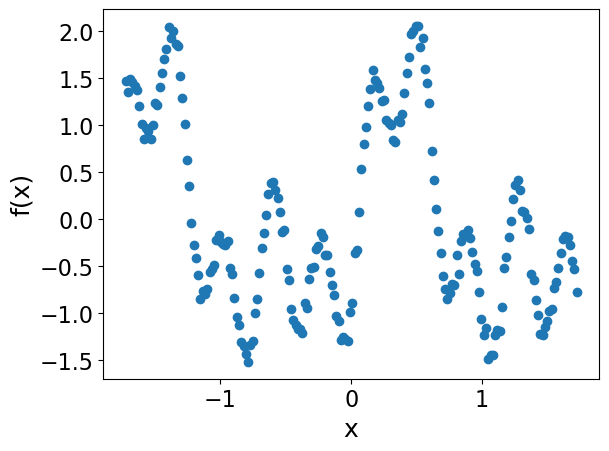

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_20_0.png)

The network's weights (called `var` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.


In [11]:
np.random.seed(0)
num_layers = 1
var_init = 0.05 * np.random.randn(num_layers, 8, requires_grad=True)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779  -0.04886389
   0.04750442 -0.00756786]]


::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ],
       [-0.04886389,  0.04750442, -0.00756786, -0.00516094,  0.02052993],
       [ 0.00720218,  0.07271368,  0.03805189,  0.00608375,  0.02219316],
       [ 0.01668372,  0.07470395, -0.01025791,  0.01565339, -0.04270479]])
```
:::

Using the Adam optimizer, we update the weights for 500 steps (this
takes some time). More steps will lead to a better fit.


In [12]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)
aux = np.Inf
var = var_init
consecutive = 0
for it in range(200):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X, Y)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))
    print(np.abs(aux-_cost))
    if(np.abs(aux-_cost) < 0.001):
        consecutive = consecutive + 1
        if(consecutive > 5):
            break
    else:
        consecutive = 0
        aux=_cost

Iter:     0 | Cost: 5.1643105 
inf
Iter:     1 | Cost: 4.8725774 
0.29173311738420793
Iter:     2 | Cost: 4.5442696 
0.3283077764223483
Iter:     3 | Cost: 4.1882774 
0.3559921899271048
Iter:     4 | Cost: 3.8121666 
0.3761107858434314
Iter:     5 | Cost: 3.4230829 
0.3890837595632659
Iter:     6 | Cost: 3.0284482 
0.39463466354024845
Iter:     7 | Cost: 2.6364995 
0.3919487091330436
Iter:     8 | Cost: 2.2566020 
0.3798975302679737
Iter:     9 | Cost: 1.8992278 
0.35737415694779306
Iter:    10 | Cost: 1.5754819 
0.32374584560690933
Iter:    11 | Cost: 1.2960947 
0.2793872732141782
Iter:    12 | Cost: 1.0699189 
0.22617577164745706
Iter:    13 | Cost: 0.9021889 
0.16773002792027325
Iter:    14 | Cost: 0.7930612 
0.10912768270990825
Iter:    15 | Cost: 0.7370988 
0.055962401840897846
Iter:    16 | Cost: 0.7241482 
0.01295054265368345
Iter:    17 | Cost: 0.7414609 
0.017312647073653098
Iter:    18 | Cost: 0.7762649 
0.03480400511060178
Iter:    19 | Cost: 0.8178179 
0.041553019375129785


Iter:   157 | Cost: 0.6591786 
0.00023662187266215717
Iter:   158 | Cost: 0.6589471 
0.00046803173141773957
Iter:   159 | Cost: 0.6587208 
0.0006943705924233878
Iter:   160 | Cost: 0.6584994 
0.000915778253878341
Iter:   161 | Cost: 0.6582828 
0.0011323945108520084
Iter:   162 | Cost: 0.6580708 
0.0002119655157259981
Iter:   163 | Cost: 0.6578634 
0.0004194222479256826
Iter:   164 | Cost: 0.6576603 
0.0006225134177141323
Iter:   165 | Cost: 0.6574614 
0.0008213830811615308
Iter:   166 | Cost: 0.6572666 
0.0010161754176057913
Iter:   167 | Cost: 0.6570757 
0.00019085845334820828
Iter:   168 | Cost: 0.6568887 
0.00037792486337528963
Iter:   169 | Cost: 0.6567053 
0.0005613387032440409
Iter:   170 | Cost: 0.6565254 
0.0007412365036807422
Iter:   171 | Cost: 0.6563489 
0.0009177515037561701
Iter:   172 | Cost: 0.6561756 
0.0010910135301500645
Iter:   173 | Cost: 0.6560055 
0.00017013554229328154
Iter:   174 | Cost: 0.6558383 
0.0003372679720016203
Iter:   175 | Cost: 0.6556741 
0.000501517

In [20]:
x_pred = Normalizar(np.linspace(0, 4*np.pi-1, num=1000))

predictions = [quantum_neural_net(var, x_) for x_ in x_pred]

and plot the shape of the function that the model has "learned" from the
noisy data (green dots).


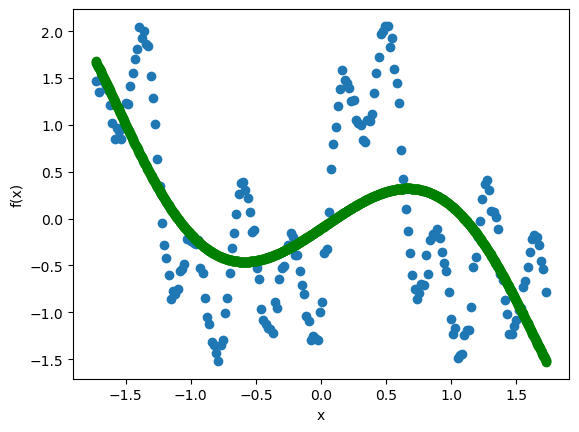

In [21]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_28_0.png)

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).


In [15]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 7

<Figure size 640x480 with 0 Axes>

![image](../demonstrations/quantum_neural_net/qnn_output_30_0.png)


About the author
================
